
[1. 통계적 모멘트 분석]

기본 통계량:
mean: 3831.1966
variance: 10899759.0867
skewness: 1.0801
kurtosis: 0.2396
median: 2385.0000
iqr: 4934.0000
coefficient_of_variation: 0.8617
mode: 0.0000
range: 16523.0000
quartile_skewness: 0.5253
0.006578108345293698

[2. 분포 적합 결과]

종합 순위 (낮을수록 better):
          distribution        type           aic           bic  test_statistic        p_value  ranking_score
2                gamma  continuous  3.221947e+05  3.222180e+05        0.090287  2.307502e-124       1.666667
3              weibull  continuous  3.224310e+05  3.224543e+05        0.090613  2.901457e-125       2.666667
5             skewnorm  continuous  3.220920e+05  3.221153e+05        0.176628   0.000000e+00       2.666667
10                beta  continuous  3.226924e+05  3.227235e+05        0.103508  2.074959e-163       3.666667
4            student_t  continuous  3.325984e+05  3.326217e+05        0.159339   0.000000e+00       5.333333
0               normal  continuous  3.326509e+05  3.326665e+05   

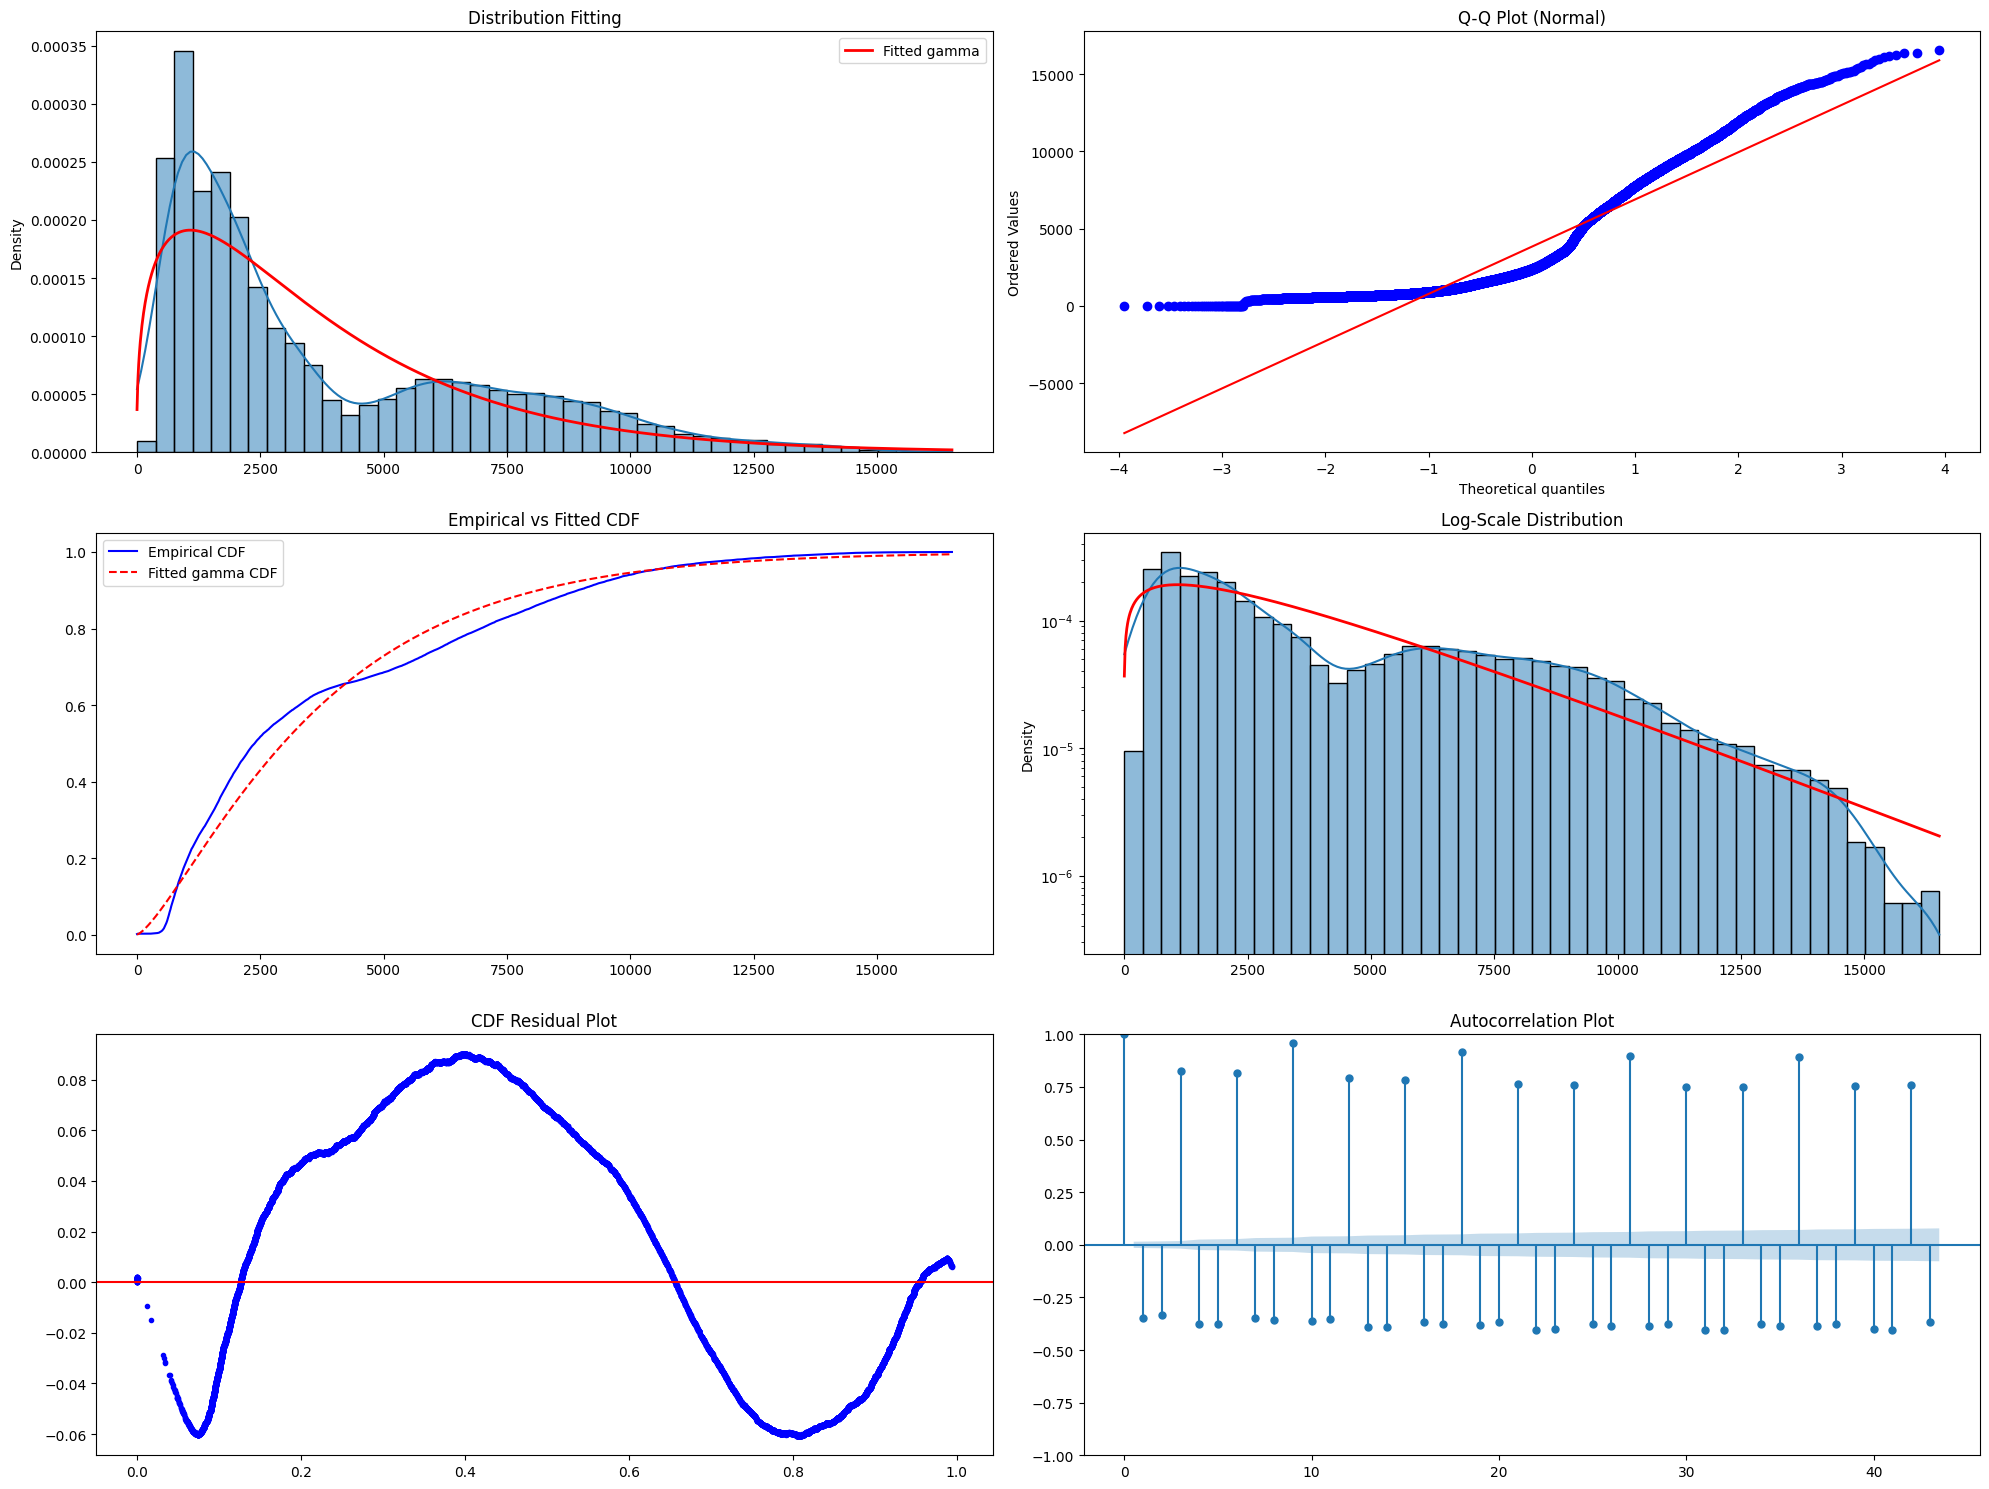


[4. 추가 분석]
- 적합도 검정 결과: 부적합
- 분포의 특성: 1.0801의 왜도와 0.2396의 첨도를 가짐
- 연속형 분포가 최적으로 선택됨 -> 데이터가 연속적 특성을 가짐


In [24]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.model_selection import KFold
import statsmodels.api as sm
from statsmodels.stats.diagnostic import lilliefors
import warnings
warnings.filterwarnings('ignore')

class DistributionAnalyzer:
    def __init__(self, data, name='sales_sum'):
        self.data = data
        self.name = name
        self.distributions = [
            {'name': 'normal', 'dist': stats.norm, 'type': 'continuous'},
            {'name': 'lognormal', 'dist': stats.lognorm, 'type': 'continuous'},
            {'name': 'gamma', 'dist': stats.gamma, 'type': 'continuous'},
            {'name': 'weibull', 'dist': stats.weibull_min, 'type': 'continuous'},
            {'name': 'student_t', 'dist': stats.t, 'type': 'continuous'},
            {'name': 'skewnorm', 'dist': stats.skewnorm, 'type': 'continuous'},  # 비대칭 정규분포
            {'name': 'poisson', 'dist': stats.poisson, 'type': 'discrete'},
            {'name': 'negative_binomial', 'dist': stats.nbinom, 'type': 'discrete'},
            {'name': 'generalized_normal', 'dist': stats.gennorm, 'type': 'continuous'},  # 일반화된 가우시안
            {'name': 'chi2', 'dist': stats.chi2, 'type': 'continuous'},
            {'name': 'f', 'dist': stats.f, 'type': 'continuous'},
            {'name': 'beta', 'dist': stats.beta, 'type': 'continuous'},
            {'name': 'cauchy', 'dist': stats.cauchy, 'type': 'continuous'},
            {'name': 'laplace', 'dist': stats.laplace, 'type': 'continuous'},  # 이중지수분포
            {'name': 'levy', 'dist': stats.levy, 'type': 'continuous'}
        ]
        
    def calculate_moments(self):
        """Calculate statistical moments and related metrics"""
        moments = {
            'mean': np.mean(self.data),
            'variance': np.var(self.data),
            'skewness': stats.skew(self.data),
            'kurtosis': stats.kurtosis(self.data),
            'median': np.median(self.data),
            'iqr': stats.iqr(self.data),
            'coefficient_of_variation': np.std(self.data) / np.mean(self.data),
            'mode': stats.mode(self.data)[0][0],
            'range': np.ptp(self.data),
            'quartile_skewness': (self.calculate_quartiles()[2] + self.calculate_quartiles()[0] - 2*self.calculate_quartiles()[1]) / 
                                (self.calculate_quartiles()[2] - self.calculate_quartiles()[0])
        }
        return moments
    
    def calculate_quartiles(self):
        """Calculate quartiles"""
        return np.percentile(self.data, [25, 50, 75])

    def fit_distributions(self):
        """Fit multiple distributions and calculate goodness-of-fit metrics"""
        results = []
        n = len(self.data)
        
        for dist_info in self.distributions:
            try:
                if dist_info['type'] == 'discrete':
                    # 이산형 분포 처리
                    if dist_info['name'] == 'poisson':
                        # 포아송 분포의 경우 lambda 파라미터 추정
                        lambda_param = np.mean(self.data)
                        params = (lambda_param,)
                        log_likelihood = np.sum(stats.poisson.logpmf(self.data, lambda_param))
                    elif dist_info['name'] == 'negative_binomial':
                        # 음이항 분포의 경우 r, p 파라미터 추정
                        mean = np.mean(self.data)
                        var = np.var(self.data)
                        p = mean/var
                        r = mean*p/(1-p)
                        params = (r, p)
                        log_likelihood = np.sum(stats.nbinom.logpmf(self.data, r, p))
                else:
                    # 연속형 분포 처리
                    params = dist_info['dist'].fit(self.data)
                    log_likelihood = np.sum(dist_info['dist'].logpdf(self.data, *params))
                
                # Calculate AIC and BIC
                k = len(params)
                aic = -2 * log_likelihood + 2 * k
                bic = -2 * log_likelihood + np.log(n) * k
                
                # Perform goodness-of-fit tests
                if dist_info['type'] == 'discrete':
                    # 이산형 분포의 경우 chi-square test 사용
                    observed_freq = np.bincount(self.data.astype(int))
                    if dist_info['name'] == 'poisson':
                        expected_prob = stats.poisson.pmf(np.arange(len(observed_freq)), params[0])
                    else:  # negative_binomial
                        expected_prob = stats.nbinom.pmf(np.arange(len(observed_freq)), params[0], params[1])
                    expected_freq = expected_prob * n
                    chi2_stat, chi2_pval = stats.chisquare(observed_freq, expected_freq[:len(observed_freq)])
                    test_stat, test_pval = chi2_stat, chi2_pval
                else:
                    # 연속형 분포의 경우 KS test 사용
                    ks_stat, ks_pval = stats.kstest(self.data, dist_info['dist'].name, params)
                    test_stat, test_pval = ks_stat, ks_pval
                
                results.append({
                    'distribution': dist_info['name'],
                    'type': dist_info['type'],
                    'log_likelihood': log_likelihood,
                    'aic': aic,
                    'bic': bic,
                    'test_statistic': test_stat,
                    'p_value': test_pval,
                    'params': params
                })
                
            except Exception as e:
                print(f"Warning: Failed to fit {dist_info['name']} distribution. Error: {str(e)}")
                continue
        
        if results:
            results_df = pd.DataFrame(results)
            results_df['ranking_score'] = (
                results_df['aic'].rank() + 
                results_df['bic'].rank() + 
                results_df['test_statistic'].rank()
            ) / 3
            return results_df
        else:
            return pd.DataFrame(columns=['distribution', 'type', 'log_likelihood', 'aic', 'bic', 
                                      'test_statistic', 'p_value', 'params', 'ranking_score'])

    def plot_diagnostic_plots(self, best_dist_info=None):
        """Create comprehensive diagnostic plots"""
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Histogram with KDE and fitted distribution
        ax1 = fig.add_subplot(321)
        sns.histplot(self.data, stat='density', kde=True, ax=ax1)
        if best_dist_info is not None:
            x = np.linspace(min(self.data), max(self.data), 1000)
            dist = next(d['dist'] for d in self.distributions if d['name'] == best_dist_info['distribution'])
            if best_dist_info['type'] == 'continuous':
                y = dist.pdf(x, *best_dist_info['params'])
                ax1.plot(x, y, 'r-', lw=2, label=f'Fitted {best_dist_info["distribution"]}')
            else:
                # For discrete distributions, plot PMF
                x = np.arange(min(self.data), max(self.data))
                y = (dist.pmf(x, *best_dist_info['params']) if best_dist_info['distribution'] == 'poisson' 
                     else dist.pmf(x, best_dist_info['params'][0], best_dist_info['params'][1]))
                ax1.plot(x, y, 'r-', lw=2, label=f'Fitted {best_dist_info["distribution"]}')
        ax1.set_title('Distribution Fitting')
        ax1.legend()
        
        # 2. Q-Q Plot
        ax2 = fig.add_subplot(322)
        stats.probplot(self.data, dist="norm", plot=ax2)
        ax2.set_title('Q-Q Plot (Normal)')
        
        # 3. Empirical CDF vs Fitted CDF
        ax3 = fig.add_subplot(323)
        if best_dist_info is not None:
            ecdf = sm.distributions.ECDF(self.data)
            x_ecdf = np.linspace(min(self.data), max(self.data), 1000)
            y_ecdf = ecdf(x_ecdf)
            ax3.plot(x_ecdf, y_ecdf, 'b-', label='Empirical CDF')
            
            dist = next(d['dist'] for d in self.distributions if d['name'] == best_dist_info['distribution'])
            if best_dist_info['type'] == 'continuous':
                y_fitted = dist.cdf(x_ecdf, *best_dist_info['params'])
            else:
                y_fitted = np.array([sum(dist.pmf(np.arange(int(x)), *best_dist_info['params'])) 
                                   for x in x_ecdf])
            ax3.plot(x_ecdf, y_fitted, 'r--', label=f'Fitted {best_dist_info["distribution"]} CDF')
        ax3.set_title('Empirical vs Fitted CDF')
        ax3.legend()
        
        # 4. Log-Scale Distribution
        ax4 = fig.add_subplot(324)
        sns.histplot(self.data, stat='density', kde=True, ax=ax4)
        ax4.set_yscale('log')
        if best_dist_info is not None and best_dist_info['type'] == 'continuous':
            ax4.plot(x, y, 'r-', lw=2)
        ax4.set_title('Log-Scale Distribution')
        
        # 5. Residual Plot
        ax5 = fig.add_subplot(325)
        if best_dist_info is not None:
            dist = next(d['dist'] for d in self.distributions if d['name'] == best_dist_info['distribution'])
            if best_dist_info['type'] == 'continuous':
                theoretical_cdf = dist.cdf(np.sort(self.data), *best_dist_info['params'])
                empirical_cdf = np.arange(1, len(self.data) + 1) / len(self.data)
                ax5.plot(theoretical_cdf, empirical_cdf - theoretical_cdf, 'b.')
                ax5.axhline(y=0, color='r', linestyle='-')
        ax5.set_title('CDF Residual Plot')
        
        # 6. Autocorrelation Plot
        ax6 = fig.add_subplot(326)
        pd.Series(self.data).autocorr()
        sm.graphics.tsa.plot_acf(self.data, ax=ax6)
        ax6.set_title('Autocorrelation Plot')
        
        plt.tight_layout()
        return fig

def main():
    try:
        # Load and prepare data
        df = pd.read_csv('../data/preprocessed/agg_df_level_6.csv')
        sales_data = df['sales_sum'].values
        
        # Initialize analyzer
        analyzer = DistributionAnalyzer(sales_data)
        
        # Calculate and print moments
        moments = analyzer.calculate_moments()
        print("\n[1. 통계적 모멘트 분석]")
        print("\n기본 통계량:")
        for k, v in moments.items():
            print(f"{k}: {v:.4f}")
        
        # Fit distributions and print results
        fit_results = analyzer.fit_distributions()
        if not fit_results.empty:
            print("\n[2. 분포 적합 결과]")
            print("\n종합 순위 (낮을수록 better):")
            sorted_results = fit_results.sort_values('ranking_score')
            print(sorted_results[['distribution', 'type', 'aic', 'bic', 'test_statistic', 
                                'p_value', 'ranking_score']].to_string())
            
            # Get best distribution
            best_dist_info = sorted_results.iloc[0].to_dict()
            print(f"\n[3. 최적 분포 분석]")
            print(f"최적 분포: {best_dist_info['distribution']}")
            print(f"분포 유형: {best_dist_info['type']}")
            print(f"AIC: {best_dist_info['aic']:.4f}")
            print(f"BIC: {best_dist_info['bic']:.4f}")
            print(f"검정 통계량: {best_dist_info['test_statistic']:.4f}")
            print(f"p-value: {best_dist_info['p_value']:.4f}")
            
            # Create diagnostic plots
            analyzer.plot_diagnostic_plots(best_dist_info)
            plt.show()
            
            # Additional insights
            print("\n[4. 추가 분석]")
            print(f"- 적합도 검정 결과: {'적합' if best_dist_info['p_value'] > 0.05 else '부적합'}")
            print(f"- 분포의 특성: {moments['skewness']:.4f}의 왜도와 {moments['kurtosis']:.4f}의 첨도를 가짐")
            
            if best_dist_info['type'] == 'discrete':
                print("- 이산형 분포가 최적으로 선택됨 -> 데이터가 카운트 성격을 가질 수 있음")
            else:
                print("- 연속형 분포가 최적으로 선택됨 -> 데이터가 연속적 특성을 가짐")
                
        else:
            print("\n분포 적합 실패")
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 왼쪽: 히스토그램과 fitted PDF
sns.histplot(data=sales_data, stat='density', kde=True, ax=ax1)
x = np.linspace(min(sales_data), max(sales_data), 1000)
ax1.plot(x, gamma.pdf(x, *params), 'r-', lw=2, label='Fitted Gamma')
ax1.set_title('(A) Histogram and Fitted Gamma PDF')

# 오른쪽: Q-Q plot
stats.probplot(sales_data, dist='gamma', sparams=params, plot=ax2)
ax2.set_title('(B) Q-Q Plot')